# HOUSEHOLD INSURANCE

the last model to be implemented for the CLTV is the household cost model.

The process is going to be similar to the one used for the automobile. The target variable is going to be the Pure Premium and a tweedie distribution will be used to follow the European standards in premium modelling matters.

Since the database doesn't count on a variable for claim numbers, with a Poisson distribution we simulate it.

As with previous analysis, the process of the analysis can be summed up with the following steps:

1. General insights: load data, create variables, correct errors and detect outliers.
2. Specific EDA: conduct an exploratory on categorical and numerical to get a better understanding and detect differential relationships
3. Modelling Pure Premium which is the target variable and the mean cost for each policy for the later CLTV.
4. Extract the predictions and concat them with the previous estimated components of the CLTV.

In [84]:
# importar librerías
import pandas as pd
import numpy as np
import os
import dill
import sys
from datetime import datetime
# seaborn
import seaborn as sns
# matplotlib
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
# plotly
import plotly.express as px
import plotly.graph_objs as go
import dash
from dash import dcc
from dash import html
from dash import Dash, dcc, html, Input, Output, State
from plotly.subplots import make_subplots
#from dash.dependencies import Input, Output, State

from scipy.stats import poisson

# scikit-learn
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import TweedieRegressor
from sklearn.dummy import DummyClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder,OrdinalEncoder,KBinsDiscretizer

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, make_scorer,mean_tweedie_deviance, d2_tweedie_score,auc,roc_auc_score

from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, roc_auc_score, log_loss

from sklearn.model_selection import GridSearchCV, cross_val_score,RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb

In [85]:
# importing the auxiliar functions

# Use raw string and ensure the path is absolute
aux_path = os.path.abspath(r'C:\Users\boloma1\OneDrive - MAPFRE\Formación\GitHub\2025\CLTV')
if aux_path not in sys.path:
    sys.path.append(aux_path)

# Now import your auxiliary functions
from aux_fun import *

# GENERAL INSIGHTS

In [86]:
# Load database
save_dir = r'C:\Users\boloma1\OneDrive - MAPFRE\Formación\GitHub\2025\CLTV\Datos\\' # Adaptar segun tu ruta

filename_list = ['bbdd_hogar','column_trans']

# Diccionario para almacenar los objetos cargados
loaded_objects = {}

# Cargar cada archivo .pkl
for i in range(len(filename_list)):
  with open(save_dir + filename_list[i] + '.pkl', 'rb') as file:
    loaded_objects[filename_list[i]] = dill.load(file)

In [87]:
df= loaded_objects['bbdd_hogar']

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59778 entries, 0 to 59777
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cliente            59778 non-null  object 
 1   fecha_nacimiento   59778 non-null  object 
 2   Prod               59778 non-null  object 
 3   contactos_ult_año  59778 non-null  int64  
 4   forma_pago         59778 non-null  object 
 5   valor_continente   59778 non-null  float64
 6   valor_contenido    59778 non-null  float64
 7   id_tran            59778 non-null  int64  
 8   mes_trans          59778 non-null  int64  
 9   prima              59778 non-null  float64
 10  productos          59778 non-null  object 
 11  id_oficina         59778 non-null  object 
 12  localizacion       59778 non-null  object 
 13  id_sin             2172 non-null   float64
 14  mes_sini           2172 non-null   float64
 15  coste_siniestro    2172 non-null   float64
dtypes: float64(6), int64(3

## Creation New Variables

In this section, new variables are created from existing ones as well as we simulate a series for number of claims with a Poisson distribution.
Also some formats of the variables are changed for later analysis and drop those unused.

In [89]:
df['fecha_nacimiento'] = pd.to_datetime(df['fecha_nacimiento'])
# Create new variables
today = datetime.today()
df['edad'] = (today - df['fecha_nacimiento']).dt.days // 365
df['contactos_ult_año']=df['contactos_ult_año'].astype('category')
df['exposicion']=1
df['coste_siniestro']=df['coste_siniestro'].fillna(0)
df['PrimaPura']=df['coste_siniestro']/df['exposicion']

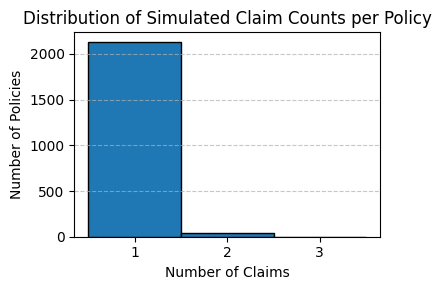

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Function to sample from a zero-truncated Poisson distribution
def zero_truncated_poisson(mu, size):
    samples = []
    while len(samples) < size:
        s = poisson.rvs(mu, size=size*2)
        s = s[s > 0]
        samples.extend(s.tolist())
    return np.array(samples[:size])

# Set parameters
n_policies = len(df.loc[df['coste_siniestro']>0])
mu_claims = n_policies/len(df)  # average number of claims per policy

# Simulate number of claims using zero-truncated Poisson
num_claims = zero_truncated_poisson(mu=mu_claims, size=n_policies)

# Visualize the distribution of simulated claim counts
plt.figure(figsize=(4, 3))
plt.hist(num_claims, bins=np.arange(1, num_claims.max()+2)-0.5, edgecolor='black')
plt.title('Distribution of Simulated Claim Counts per Policy')
plt.xlabel('Number of Claims')
plt.ylabel('Number of Policies')
plt.xticks(range(1, num_claims.max()+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [91]:
# Create number of claims variable
df.loc[df['coste_siniestro']>0,'NSin']=num_claims
df.loc[df['coste_siniestro']==0,'NSin']=0

In [92]:
df.drop(['fecha_nacimiento','id_tran','id_sin','mes_trans','mes_sini'],axis=1,inplace=True)

In [93]:
num_cols=[]
cat_cols=[]

# Listas con variables numéricas y categóricas
[cat_cols.append(x) if df[x].dtypes in ('object','category','datetime') else num_cols.append(x) for x in df.columns ]
num_cols.remove('exposicion');

## Correct errors and outliers

In this step, we look for outlier values in the numeric variables. Extreme values will be removed. For a deeper analysis of the metric used for detecting outliers, you can look at the auxiliary functions in a python script (aux_fun.py).

Finally we can look at the distribution of the numeric variables once outliers are removed to check for consistency.

In [94]:
detect_outliers(df,num_cols=num_cols)

,Variable,Num. outliers,Outlier Threshold,% Outliers
0,valor_continente,764,393544.0,1.28
1,valor_contenido,3,11692958.0,0.01
2,prima,732,443.0,1.22
3,coste_siniestro,1149,3544.0,1.92
4,edad,52,109.0,0.09
5,PrimaPura,1149,3544.0,1.92
6,NSin,2172,1.0,3.63


In [95]:
clients_ids = []
clients_ids.extend(df.loc[df['edad']>=108,'cliente'].to_list())
clients_ids.extend(df.loc[df['edad']<=21,'cliente'].to_list())
clients_ids.extend(df.loc[df['valor_continente']>=390000,'cliente'].to_list())
clients_ids.extend(df.loc[df['valor_contenido']>=100000,'cliente'].to_list())

#clients_ids.extend(df.loc[df['prima']>=732,'cliente'].to_list())


In [96]:
df['Multiplier']=[x/15941 if x>15941 else 1 for x in df['coste_siniestro']]
df.loc[df['coste_siniestro']>15941,'coste_siniestro']=15941
df['coste_siniestro']=df['coste_siniestro'].fillna(0)

In [97]:
clients_ids = list(set(clients_ids))

In [98]:
df = df[df['edad']<108]
df = df[df['edad']>21]
df = df[df['valor_continente']<390000]
df = df[df['valor_contenido']<100000]

In [99]:
def graph_hist_numeric(
        df:pd.DataFrame,
        num_cols:list
):
    app = Dash(__name__)

    app.layout = html.Div([
        html.H4('Distribution of Numeric Columns'),
        dcc.Dropdown(id='dropdown',options=num_cols,value='coste_siniestro'),
        dcc.Graph(id='histogram')
    ])

    @app.callback(Output('histogram','figure'),
                Input('dropdown','value'))

    def histograma(col):
        fig = px.histogram(df.loc[df['coste_siniestro']>0],x=col,marginal='box')
        return fig

    app.run(debug=True,port=1122)


In [100]:
graph_hist_numeric(df,num_cols)

# EDA

A deeper analysis onto the categorical and numerical variables is conducted.

* Tabla comparativa para variable categórica y numérica por tramos, con los valores de Loss Ratio (Siniestralidad/Primas) y Prima Pura (Incurrido/Num Siniestros).
* Correlograma numéricas y categóricas (V Cramer)

Hay que sacar los gastos de gestión y adquisición por oficina y luego aplicarlo a la bbdd total.

## Categorical variables

Here we only show some plots and tables for categorical data but the analysis should be performed during the exploratory analysis to the entire dataset. The analysis consists on:

* Distribution plot of the target variable against the categories of a variable.
* Creation of an economic situation summary table with calculated measure such as frequency or loss ratio, to look for differential categories inside categorical variables.
* Plotting target variable and loss ratio for categorical data.

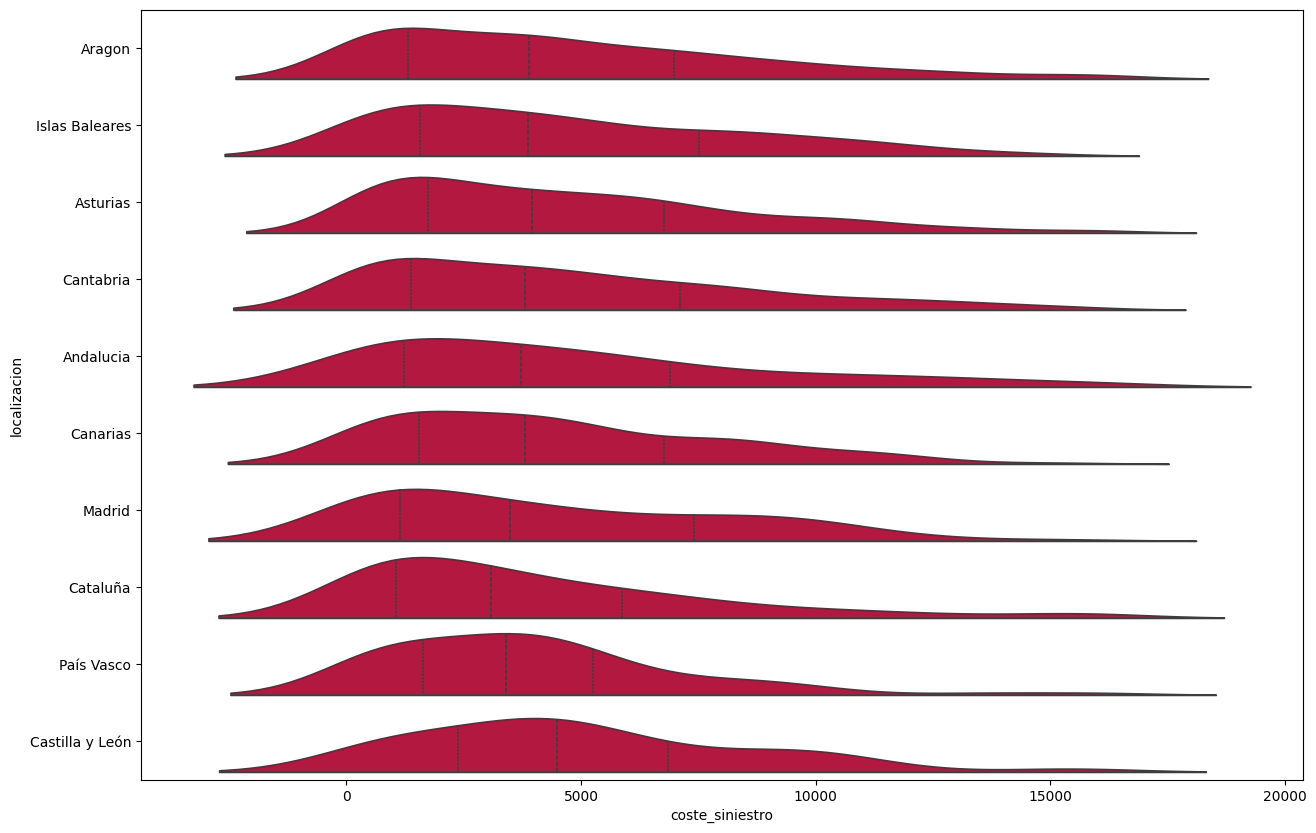

In [101]:
# Generate a violintplot for each category in y axis and distribution of numeric variable in x axis.
plt.figure(figsize=(15,10))
sns.violinplot(data=df.loc[df['coste_siniestro']>0], x="coste_siniestro", y="localizacion", split=True, inner="quart",color='#cc0033')
plt.show()

In [102]:
tabla_siniestralidad_cat(df,['coste_siniestro','prima','NSin','exposicion'],'localizacion')

,NSin,coste_siniestro,exposicion,prima,severidad,Frecuencia,PrimaPura,RC
localizacion,,,,,,,,
Andalucia,100.0,477585.52,3600,774085.26,4775.855200,0.027778,132.662644,0.616968
Aragon,351.0,1631465.05,4380,946176.16,4648.048575,0.080137,372.480605,1.724272
Asturias,433.0,1981689.35,8316,1816338.39,4576.649769,0.052068,238.298383,1.091035
Canarias,127.0,558862.22,4068,880790.42,4400.489921,0.031219,137.380093,0.634501
Cantabria,301.0,1384885.55,8382,1810489.94,4600.948671,0.035910,165.221373,0.764923
Castilla y León,80.0,394464.34,8300,1782087.23,4930.804250,0.009639,47.525824,0.221350
Cataluña,150.0,595793.61,4633,997008.75,3971.957400,0.032376,128.597801,0.597581
Islas Baleares,171.0,774208.73,5893,1271135.24,4527.536433,0.029017,131.377690,0.609069
Madrid,90.0,388309.95,8249,1777360.69,4314.555000,0.010910,47.073579,0.218476


In [103]:
lossratio_graph(df,category='forma_pago')

In [104]:
accident_summary(df,'localizacion')

## Numerical variables

For numeric variables the attention will be paid on:

* Correlations. With the help of a correlogram, one can hover over the variables to look for the correlation between them.
* A table as with categorical data to summarize KPI's ordering the data by ranges.

In [105]:
# Correlogram
correlation = df[num_cols].corr()
fig = go.Figure(go.Heatmap(
    x=correlation.columns,
    y=correlation.columns,
    z=correlation.values.tolist(),
    zmin=-1,zmax=1,colorscale='rdylgn'
))

fig.update_layout(title='Correlation Numeric Variables',
    autosize=False,
     width=500,
     height=500,
     margin=dict(l=100, r=100, b=100, t=100),
     xaxis=dict(tickangle=45)
)

fig.show()

In [106]:
def tabla_siniestralidad_num(
        df:pd.DataFrame,
        col: str,
        range: int):
    num_grupos = np.linspace(df[col].min(),df[col].max(),range)
    tabla= df.groupby(by=pd.cut(df[col],num_grupos),observed=True)[['coste_siniestro','NSin','exposicion','prima']].sum()\
                                                                                        .assign(severidad=lambda x: x['coste_siniestro']/x['NSin'])\
                                                                                        .assign(Frecuencia = lambda x : x['NSin']/x['exposicion'])\
                                                                                        .assign(PrimaPura = lambda x : x['coste_siniestro']/x['exposicion'])\
                                                                                        .assign(LossRatio= lambda x : x['coste_siniestro']/x['prima'])
    return tabla

In [107]:

edad_accident = tabla_siniestralidad_num(df,'edad',7).round(2)


# Create a Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=list(edad_accident.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[edad_accident[col] for col in edad_accident.columns],
               fill_color='lavender',
               align='left'))
])
fig.show()

In [108]:
edad_accident

,coste_siniestro,NSin,exposicion,prima,severidad,Frecuencia,PrimaPura,LossRatio
edad,,,,,,,,
"(22.0, 36.167]",2609010.13,583.0,1171,229425.26,4475.15,0.50,2228.02,11.37
"(36.167, 50.333]",4898687.43,1081.0,10965,2269126.16,4531.63,0.10,446.76,2.16
"(50.333, 64.5]",968879.07,212.0,19384,4175417.25,4570.18,0.01,49.98,0.23
"(64.5, 78.667]",12691.16,4.0,17078,3767292.40,3172.79,0.00,0.74,0.00
"(78.667, 92.833]",0.00,0.0,8626,1910109.48,NaN,0.00,0.00,0.00
"(92.833, 107.0]",0.00,0.0,1306,287710.09,NaN,0.00,0.00,0.00


# REGRESSION MODEL

After conducting the exploratory analysis, we are familiarized with the main characteristics of the variables contained in the dataset. Thus, we are able to start modelling the target variable "Pure Premium" to try predict the cost of the policy after one year in the company.

This estimated cost will be applied in the CLTV and aged along the n years that lasts the analysis. For the premiums, the actual data will be used for those that already have an auto and household insurance. For the remaining policies, those only with auto insurance, we will take the pure premium and increase it as if we would offer a commercial premium, so we can estimate a CLTV for the whole portfolio (may be we just use the clients with both, auto and house insurance).

The process for modelling will be as follows:

* Create a preprocessor to standarize or categorize for numeric variables and convert to dummy variables with the OneHotEncoder the categorical data.
* Definition of the model to be implemented. In this case to be homogeneous, the Tweedie Regressor will be used with a power of 1.5.
* Creation of a dummy regressor to make comparable the results obtained from a random model with respect the tweedie model.
* Lorenz curve to compare the best possible model (oracle) to the tweedie model. It uses the GINI metric for calculating goodness of fit.
* Plot the predictions and the actual values summarized against a continuous variable, to see whether the observed target variable adjusts similar to the predicted ones.
* Table that holds both coefficients as log odds and the odds ratio so one can examinate feature importance. A barplot is also represented to better look for the covariates with a stronger influence into the model.

* EXPLINAIBILITY with FEATURE importance SCORES (from Datacamp course)
* SHAP explainers:
    * General explainer
    * Type-specific explainer
* Eliminar valor_contenido, valor_continente para hacerlo escalable a los clientes de solo autos de los cuales no tenemos estos datos.

In [109]:

# Definition of the column transformer that will be used as the preprocessor
column_trans = ColumnTransformer(
    [
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=7, random_state=0),
            ["edad"],
        ),
        #('std_scaler',
        # StandardScaler(),
        # ['valor_continente','valor_contenido']),
        (
            "onehot_categorical",
            OneHotEncoder(),
            [ "forma_pago", "localizacion"],
        ),
        (
            'ordinal_encoder',
            OrdinalEncoder(),
            ['contactos_ult_año']
        )
    ],
    remainder="drop",verbose_feature_names_out=False
)
X = column_trans.fit_transform(df)


In [110]:

# Get feature names
feature_names = column_trans.get_feature_names_out()

# Create a DataFrame with the transformed data and feature names
#X_df = pd.DataFrame(X, columns=feature_names)
feature_names


array(['edad_0.0', 'edad_1.0', 'edad_2.0', 'edad_3.0', 'edad_4.0',
       'edad_5.0', 'edad_6.0', 'forma_pago_ANUAL', 'forma_pago_MENOR',
       'forma_pago_SEMESTRAL', 'localizacion_Andalucia',
       'localizacion_Aragon', 'localizacion_Asturias',
       'localizacion_Canarias', 'localizacion_Cantabria',
       'localizacion_Castilla y León', 'localizacion_Cataluña',
       'localizacion_Islas Baleares', 'localizacion_Madrid',
       'localizacion_País Vasco', 'contactos_ult_año'], dtype=object)

In [111]:
# Split the original dataframe and the transformed for later purposes
df_train, df_test, X_train, X_test = train_test_split(df, X, random_state=0)

In [112]:
# W check that tweediepower of 1.5 is the best option with a grid search
modelo_tweedie = TweedieRegressor(solver="newton-cholesky")

param_grid = {'power':[1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]}

deviance_scorer = make_scorer(mean_tweedie_deviance, greater_is_better=False, power=1.5)

grid_search = GridSearchCV(estimator=modelo_tweedie,
                           param_grid=param_grid,
                           scoring=deviance_scorer,
                           cv=5)

In [113]:
grid_search.fit(
    X_train, df_train["PrimaPura"], sample_weight=df_train["exposicion"]
)
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Predict using the best model
y_pred = grid_search.predict(X_test)

Best parameters found:  {'power': 1.5}


Once fitted the model, we calculate metrics to compare the goodness of fit against a dummy regressor.

In [114]:
# Evaluate the model
deviance = mean_tweedie_deviance(df_test['PrimaPura'], y_pred, power=1.5)
print("Mean Tweedie Deviance: ", deviance)

# Calculate the D² Tweedie score
d2_score = d2_tweedie_score(df_test['PrimaPura'], y_pred, power=1.5)

print('D² Tweedie score:',round(d2_score,4))

Mean Tweedie Deviance:  49.36645034772879
D² Tweedie score: 0.3906


Obtain the dummy model and its predictions.

In [115]:
from sklearn.dummy import DummyRegressor

dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(
    X_train,
    df_train["PrimaPura"],
    sample_weight=df_train["PrimaPura"],
)

y_dummy_pred = dummy_model.predict(X_test)


Comparing the deviance and the d2 score, the tweedie model overcomes the dummy model, presenting good results.

In [116]:
# Evaluate the model
deviance = mean_tweedie_deviance(df_test['PrimaPura'], y_pred, power=1.5)
print("Mean Tweedie Deviance: ", deviance)

dummy_deviance = mean_tweedie_deviance(df_test['PrimaPura'], y_dummy_pred, power=1.5)
print("Mean Dummy Deviance: ", dummy_deviance)

print('D² Tweedie score:',round(d2_score,4))

d2_score_dummy = d2_tweedie_score(df_test['PrimaPura'], y_dummy_pred, power=1.5)

print('D² Dummy score:',round(d2_score_dummy,4))

Mean Tweedie Deviance:  49.36645034772879
Mean Dummy Deviance:  341.86031262239385
D² Tweedie score: 0.3906
D² Dummy score: -3.2202


Plot the lorenz curve to obtain GINI from the tweedie model.

In [33]:
def lorenz_curve(y_true, y_pred, exposure):

    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # Ordeno la muestra según el riesgo predicho (de menor a mayor riesgo):
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]

    # Calculo la prima pura acumulada:
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))

    return cumulated_samples, cumulated_claim_amount

def add_lorenz_plot(ax, y_test, y_pred, exposure, label, linestyle='-', color='gray'):

  # Construyo la curva de Lorenz
  ordered_samples, cum_claims = lorenz_curve(y_test, y_pred, exposure)

  # Determino el coeficiente de Gini:
  gini = 1 - 2 * auc(ordered_samples, cum_claims) # Tambien se calcula con el area de la curva de ROC
  label += " (Gini: {:.3f})".format(gini)

  # Dibujo la curva de Lorenz
  ax.plot(ordered_samples, cum_claims, linestyle=linestyle, color=color,
        label=label)

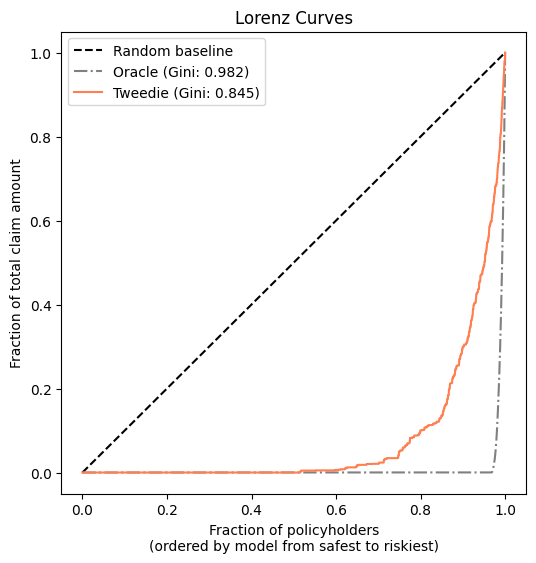

In [117]:
fig, ax = plt.subplots(figsize=(6, 6))

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black",
        label="Random baseline")

# Oracle model: y_pred == y_test
add_lorenz_plot(ax, df_test['PrimaPura'], df_test['PrimaPura'], df_test['exposicion'], 'Oracle', linestyle="-.", color="gray")

# Regressor
add_lorenz_plot(ax, df_test['PrimaPura'], y_pred, df_test['exposicion'], 'Tweedie', linestyle="-", color="coral")


ax.set(
    title="Lorenz Curves",
    xlabel=('Fraction of policyholders\n'
            '(ordered by model from safest to riskiest)'),
    ylabel='Fraction of total claim amount'
)
ax.legend(loc="upper left")

In the following graph we look at the numeric variable age and compare the observed data against the predicted. We can deduct that age has a relevant weigth in the model, from the shape of the line. Younger ages present a riskier profile to older ones, however, the data looks overdispersed at early ages and with less exposure. This has to be taken into account if we want to extract conclusions from the analysis. Since the objective of this work is to give the necessary tools to conduct a CLTV, we won't get deeper.

In [35]:
def plot_obs_pred(
    df,
    feature,
    weight,
    observed,
    predicted,
    y_label=None,
    title=None,
    ax=None,
    fill_legend=False,
):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )


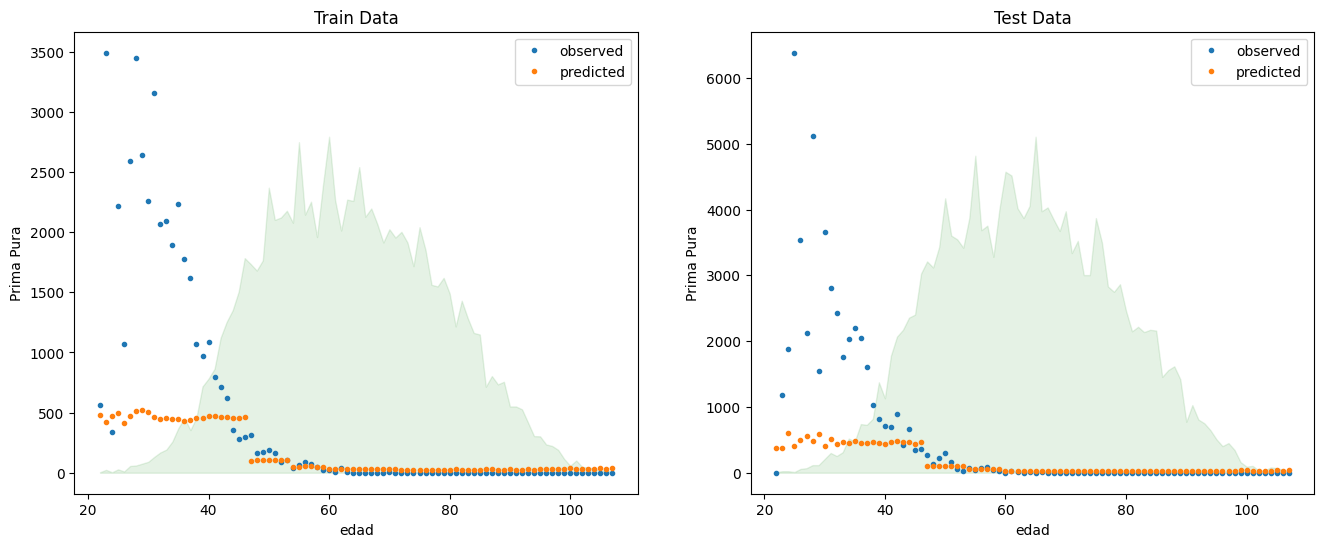

In [118]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plot_obs_pred(df=df_train,
              feature='edad',
              weight='exposicion',
              observed='PrimaPura',
              predicted=grid_search.predict(X_train),
              y_label='Prima Pura',
              title='Train Data',
              ax=ax[0])

plot_obs_pred(df=df_test,
              feature='edad',
              weight='exposicion',
              observed='PrimaPura',
              predicted=grid_search.predict(X_test),
              y_label='Prima Pura',
              title='Test Data',
              ax=ax[1])

The last point of analysis is a summary table with the coefficients as log odds and the odds ratio, which is the exponential value of the coefficients. With these we can interpret the feature importance. Generally explained, odds ratio close to the vertical line in 0 (x axis), means the variable has no or little effect on the model. As we go to either sides (positive or negative) the feature importance gains weight.
As commented just before, early ages increase the likelihood to have a higher premium while as people get older they tend to have lower costs. Another interesting analysis is to look at the differences in the location of the policy of the household.

In [119]:
model_def = grid_search.best_estimator_
coefficients = model_def.coef_
summary = pd.DataFrame({
    'Features':feature_names,
    'Coefficients':coefficients,
    'Odds Ratio':np.exp(coefficients)
}).sort_values(by='Odds Ratio',ascending=False)
summary

,Features,Coefficients,Odds Ratio
0,edad_0.0,2.166966,8.731754
1,edad_1.0,0.656644,1.928311
12,localizacion_Asturias,0.563160,1.756214
11,localizacion_Aragon,0.561823,1.753867
9,forma_pago_SEMESTRAL,0.125124,1.133289
14,localizacion_Cantabria,0.082427,1.085920
20,contactos_ult_año,0.078348,1.081499
16,localizacion_Cataluña,0.008919,1.008959
13,localizacion_Canarias,-0.005284,0.994730
10,localizacion_Andalucia,-0.015412,0.984706


In [120]:
fig = px.bar(data_frame=summary,x='Coefficients',y='Features',hover_data=['Odds Ratio'])
fig.add_vline(x=0,line_width=3,line_color='black')
fig.show()

## PREDICTIONS

Finally, extract the predictions for the cost model and we are able to put all together the final CLTV.

In [121]:
X = df
y = df['PrimaPura']

In [122]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=43)

In [123]:
model_def = grid_search.best_estimator_

In [124]:
preprocessor_cost = Pipeline([('column_transformer',column_trans),
                              ( 'modelo_coste',model_def)])

In [125]:
preprocessor_cost.fit(X_train,y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('binned_numeric',
                                                  KBinsDiscretizer(n_bins=7,
                                                                   random_state=0),
                                                  ['edad']),
                                                 ('onehot_categorical',
                                                  OneHotEncoder(),
                                                  ['forma_pago',
                                                   'localizacion']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(),
                                                  ['contactos_ult_año'])],
                                   verbose_feature_names_out=False)),
                ('modelo_coste',
                 TweedieRegressor(power=1.5, solver='newton-cholesky'))])

At this point, we have to age the numeric variables for the correct calculation of the CLTV along the period of analysis.

In [126]:
X=df.copy()
for i in range(0,5):
    column_name = f'House_Cost_y_{i+1}'
    X[["edad"]]+=1
    X[column_name] = preprocessor_cost.predict(X)

In [127]:
X

,cliente,Prod,contactos_ult_año,forma_pago,valor_continente,valor_contenido,prima,productos,id_oficina,localizacion,...,edad,exposicion,PrimaPura,NSin,Multiplier,House_Cost_y_1,House_Cost_y_2,House_Cost_y_3,House_Cost_y_4,House_Cost_y_5
0,A1500471SD,Ambos,0,ANUAL,300000.0,40000.0,358.45,201H,sucursal4,Andalucia,...,40,1,0.0,0.0,1.0,415.058815,415.058815,415.058815,415.058815,415.058815
1,A1508494TS,Ambos,1,ANUAL,61000.0,21100.0,170.21,201H,Canalonline,Asturias,...,66,1,0.0,0.0,1.0,49.134875,49.134875,49.134875,49.134875,47.718141
2,A1515609BI,Ambos,1,ANUAL,144800.0,45000.0,238.55,201H,sucursal7,Canarias,...,53,1,0.0,0.0,1.0,93.325546,93.325546,93.325546,93.325546,93.325546
3,A1522302NJ,Ambos,2,ANUAL,96000.0,25000.0,201.85,201H,sucursal10,País Vasco,...,56,1,0.0,0.0,1.0,98.832019,98.832019,46.721824,46.721824,46.721824
4,A1529153OQ,Ambos,0,ANUAL,184000.0,36000.0,270.66,201H,sucursal5,Aragon,...,81,1,0.0,0.0,1.0,37.742213,37.742213,37.742213,37.025401,37.025401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59773,Z88912285BH,Solo Hogar,1,ANUAL,75598.0,32224.0,186.88,201H,sucursal4,Andalucia,...,81,1,0.0,0.0,1.0,23.233326,23.233326,23.233326,22.792072,22.792072
59774,Z88920719HB,Solo Hogar,2,ANUAL,55000.0,15000.0,169.58,201H,sucursal3,Madrid,...,56,1,0.0,0.0,1.0,64.766092,64.766092,30.617506,30.617506,30.617506
59775,Z88944263NF,Solo Hogar,2,ANUAL,101700.0,24000.0,210.66,201H,sucursal10,País Vasco,...,81,1,0.0,0.0,1.0,23.982188,23.982188,23.982188,23.526710,23.526710
59776,Z88944665QP,Solo Hogar,2,ANUAL,90000.0,15000.0,194.35,201H,sucursal5,Aragon,...,68,1,0.0,0.0,1.0,50.121366,50.121366,48.676188,48.676188,48.676188


In [ ]:
X.drop(columns=['mes_trans','mes_sini','id_oficina'],axis=1,inplace=True)

No vamos a introducir el modelo de cross selling por falta de datos en las bbdd. No contamos con la marca, el tipo de vehículo o la antigüedad del carnet.

Unir el modelo de coste de hogar al de autos. En el merge si contamos con el df_final de hogar a la izquierda y el de autos a la derecha entonces el how='left'.